AirBnB data for predicting the country of first destination is readily
available online (Kaggle). Can this same data be used to define/solve 
other business problems or create new opportunities?

One idea for this project is to create a seperate business case (project) using the same data. 

<p><b>Project:</b></p>

<b>Note: This analysis does not include any 2020 data. </b>

Project: Days until revenue collected (days until first booking).

It takes around 4 days before a user first books on AirBnB. 
When session data is included the MAD (median absolute deviation) decreases drastically from 7 to 0.13. However the test score is lower than the train score which shows there is a variance problem. In this case the model can be improve by having more data.

The main observations from this project are:
    1. Missing values can skew the results
    2. Finding a way to change the number of variables (bias) and 
    observations (variance) with limited project resources
    3. Choice of model and metric using nonlinear algorithms
    4. How to handle unexpected results
        i. Transform output variable
        ii. Parameter tuning
 
Source: Statista and iProperty Manement

In [228]:
###### from pyspark import SparkContext
#import pyspark.sql #import SparkSession
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import os
#import rpy2 
#import rpy2.robjects.packages as packages
#import rpy2.robjects.lib.ggplot2 as ggplot2
#import rpy2.robjects as ro
import math
import numpy as np
import pandas as pd
import pickle
#import blaze as bz
import pyspark as py
from time import time
from collections import Counter
import scipy.stats as ss
import statsmodels as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import RDD
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameReader
from pyspark.sql import DataFrameWriter
from pyspark.sql import types
from pyspark.sql.types import StructType, IntegerType, StringType, DecimalType, FloatType
from pyspark.sql import DataFrameNaFunctions, DataFrameStatFunctions as statFunc
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from sklearn import preprocessing 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sb

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel, LabelSet
from bokeh.transform import factor_cmap, jitter
from bokeh.palettes import Paired12, Spectral6, Viridis3

#Display bokeh graphis in a notebook
output_notebook()

Loading BokehJS ...

## Setup Spark environment

In [2]:
os.environ['JAVA_HOME'] = "C:\\Program Files\\Java\\jdk1.8.0_191"

In [3]:
conf = SparkConf().set("spark.home", "C:\\MathLabASUS\\SW\\DM\\spark-2.4.0-bin-hadoop2.7") \
.set("spark.driver.extraClasspath", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1") \
.set("spark.driver.extraClasspath", "org.mongodb:mongo-java-driver:3.9.0") \
.set("spark.submit.deployMode", "client") \
.set("spark.driver.memory", "5G") \
.set("spark.driver.maxResultSize", "5G")  

In [4]:
sc = py.SparkContext("local[1]", conf=conf)

sc.stop()

In [5]:
sqlContext = SQLContext(sc)

The project can be divided into three categories of data:
    1. Session - "search" pages, time
    2. Demographics - age, gender
    3. Website - ads, devices, apps

### Session

In [6]:
session_df = sqlContext.read.csv("sessions.csv", \
                    header = True, mode = "DROPMALFORMED")

#### Fill in missing values for session variables

In [7]:
session_df[["action", "action_type", "action_detail", "device_type"]].fillna("None")

DataFrame[action: string, action_type: string, action_detail: string, device_type: string]

#### Save session as a spark table

In [87]:
session_df.registerTempTable("session_df")

#### Define user actions and time spent in a session

In [9]:
%%time
action_df = sqlContext.sql("SELECT action, AVG(secs_elapsed) AS mean_secs FROM \
            session_df \
            GROUP BY action \
          ")
action_df = action_df.withColumn("mean_mins", col("mean_secs")/float(60.0))

Wall time: 178 ms


#### Distribution of time spent in minutes in an airbnb session

In [10]:
hist, edges = np.histogram(action_df.toPandas()["mean_mins"], density = True, \
                           bins = "auto")

In [11]:
output_notebook()

session_data = ColumnDataSource(data = action_df.toPandas())
plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)
plot.quad(bottom=0, top = hist, left = edges[:-1], \
          right = edges[1:], \
          fill_color = "blue", line_color = "white", alpha = 0.8, \
         hover_fill_color = "green")
plot.title.text = 'Distribution of time spent on airbnb (in a session)'
plot.xaxis.axis_label = 'Average time (minutes)'
plot.yaxis.axis_label = 'Frequency'
hover = HoverTool(tooltips = [('Frequency', '@{Frequency}{,}'), \
                              ('Average time (minutes)', '@hist'), ])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

#### Outliers for time spent in a session

In [12]:
stat = action_df.toPandas()["mean_mins"].describe()
print(stat)
IQR = stat["75%"] - stat["25%"]
lower = stat["25%"] - 1.5 * IQR
upper = stat["75%"] + 1.5 * IQR
print("Lower and upper bounds for outliers are {} and {}" .format(lower, upper))

count      244.000000
mean      1084.838911
std       1826.719500
min          6.288889
25%        202.828902
50%        525.353383
75%       1221.772222
max      17526.916667
Name: mean_mins, dtype: float64
Lower and upper bounds for outliers are -1325.5860771495559 and 2750.1872018452887


Most user actions on the website take less than 5,000 minutes. In fact anything above 3,000 might be considered an outlier (visually). Most users probably leave the web browser open while engaging in other activities. Three to five hours (180-300 minutes) on average in each session is a better assessment of session time. Time spent (in minutes) does not seem useful at this stage.
Look at user actions in a session.

#### Remove outliers

In [86]:
session_df.columns

['user_id',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'secs_elapsed']

In [13]:
%%time
action_df_no_outliers = action_df.filter(col("mean_mins") <= \
                                         upper).sort(desc("mean_mins"))

Wall time: 75.8 ms


In [15]:
action_df_no_outliers.registerTempTable("session_no_outliers_df")

#### User actions in a session

In [17]:
action_df_no_outliers[["action", "mean_mins"]].sort(desc("mean_mins")).toPandas().head(10)

,action,mean_mins
0,guest_booked_elsewhere,2628.675758
1,salute,2592.568452
2,concierge,2546.509574
3,email_itinerary_colorbox,2438.750725
4,upload,2360.505952
5,receipt,2197.319697
6,mobile_landing_page,2171.846667
7,cancellation_policies,2155.751487
8,other_hosting_reviews,2152.487971
9,press_release,2080.176190


#### Get more details on user actions in a session

In [18]:
session_group = Window().partitionBy("action", "action_type", "action_detail")
session_actions_df = session_df.withColumn("secs_elapsed", \
                                   when(col("secs_elapsed").isNull(), \
                                        count(col("secs_elapsed")).over(session_group)).otherwise(col("secs_elapsed"))) 

In [19]:
%%time
# Remove outliers
session_actions_df = session_actions_df.filter(col("secs_elapsed")/60 <= \
                                         upper).sort(desc("secs_elapsed"))
session_actions_df = session_actions_df.withColumn("mins_elapsed", col("secs_elapsed")/float(60.0))

Wall time: 131 ms


In [20]:
session_actions_df.registerTempTable("session_actions_df")

#### Find and plot top 10 user activities (action, action type, and action detail) by count and average minutes

In [21]:
%%time
user_activity_df = sqlContext.sql("SELECT action, action_type, \
                        action_detail, \
                        COUNT(action, action_type, action_detail) as count, \
                        PERCENTILE_APPROX(secs_elapsed, 0.5) AS avg_secs, \
                        PERCENTILE_APPROX(secs_elapsed, 0.5)/60 AS avg_mins \
                        FROM session_actions_df \
                        GROUP BY action, action_type, action_detail \
          ")

Wall time: 72.5 ms


#### Top 10 user activities

In [22]:
user_activity_df = user_activity_df.withColumn("activity", concat(lit("["), col("action"), lit(", "), col("action_type"), lit(", "), col("action_detail"), lit("]")))
user_activity_pd_df = user_activity_df.select("activity", "count", "avg_mins").distinct().sort(desc("count")).toPandas() #.dropDuplicates(["activity", "mean_mins"]).collect()
user_activity_pd_df[["activity", "count", "avg_mins"]].head(10)#.sort_values("activity", ascending = True)

,activity,count,avg_mins
0,"[search_results, click, view_search_results]",104472,84.816667
1,"[personalize, data, wishlist_content_update]",103815,16.850000
2,"[show, view, p3]",92871,182.933333
3,"[ajax_refresh_subtotal, click, change_trip_cha...",70071,14.266667
4,"[similar_listings, data, similar_listings]",52940,2.866667
5,"[index, view, view_search_results]",38274,286.766667
6,"[update, submit, update_listing]",27775,175.850000
7,"[show, view, user_profile]",23653,7.400000
8,"[search, click, view_search_results]",22200,33.450000
9,"[header_userpic, data, header_userpic]",16934,18.500000


Most customers or users spend the time  before booking in various activities - search and personalizing data

### Demographics

In [23]:
train_user_df = sqlContext.read.csv("train_users_2.csv", \
                    header = True, mode = "DROPMALFORMED")

In [42]:
train_user_df.count()

213451

#### Get an idea about age distribution before replacing null values

In [24]:
age_list = [val[0] for val in train_user_df.select(col("age")).collect()]

age_pd_df = pd.DataFrame(age_list, columns = ["age"])

age_pd_df.count()

age    125461
dtype: int64

#### Distribution of age variable

In [25]:
age_pd_df.dropna(subset = ["age"], inplace = True)

age_hist = age_pd_df.groupby("age").size().reset_index(name = "count")
age_hist["age"] = age_hist["age"].astype(float)

output_notebook()

session_data = ColumnDataSource(data = age_hist)

age = session_data.data['age'].tolist()

plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)

plot.vbar(x = "age", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = 'Age distribution of AiBnB customers'
plot.xaxis.axis_label = 'Age'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Age', '@age'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

Some incorrect values for age 105 and over. Remove these errors or outliers and ages below 18.

In [26]:
age_pd_df = age_pd_df[(age_pd_df["age"].astype(int) >= 18) & (age_pd_df["age"].astype(int) < 105)]
age_pd_df["age"] = age_pd_df["age"].astype(float)
age_hist = age_pd_df.groupby("age").size().reset_index(name = "count")

In [27]:
plot_title = "70.0% of AirBnB customers are between 25 and 45"

In [28]:
output_notebook()

session_data = ColumnDataSource(data = age_hist)

plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)

plot.vbar(x = "age", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = plot_title
plot.xaxis.axis_label = 'Age'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Age', '@age'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

In [29]:
majority = np.round((np.sum(age_hist[(age_hist["age"] >= 25) & (age_hist["age"] <= 45)]["count"])/np.sum(age_hist["count"])), 1) * 100

In [30]:
print("{}% of AirBnB customers are between 25 and 45 (working age)" .format(majority))

70.0% of AirBnB customers are between 25 and 45 (working age)


#### Distribution of gender variable

Text(0.5, 1.0, '30% of users are female and 25% are male')

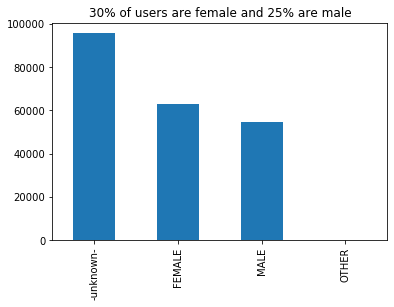

In [46]:
gender_dist = train_user_df.toPandas()["gender"].value_counts().plot(kind = "bar")
plt.title("30% of users are female and 25% are male")

#### Convert date columns to date types

In [47]:
train_user_df = train_user_df.withColumn("date_account_created", to_date("date_account_created", "yyyy-MM-dd"))
train_user_df = train_user_df.withColumn("date_first_booking", to_date("date_first_booking", "yyyy-MM-dd"))
train_user_df = train_user_df.withColumn("timestamp_first_active", to_timestamp(train_user_df.timestamp_first_active, "yyyyMMddHHmmss")).alias("timestamp_first_active")

In [48]:
train_user_df.registerTempTable("train_user_df")

In [49]:
train_user_pd_df = train_user_df.toPandas()

##### Placeholder to save train_user_pd_df dataframe

train_user_pd_df.to_csv("train_user_pd_df.csv", index = False)

##### Read the train_user pandas dataframe file from csv

train_user_pd_df = pd.read_csv("train_user_pd_df.csv")

##### End of placehoder

### Website (visualization of website variables)

#### Visitors to AirBnB website via gender and signup method

In [85]:
gender_by_signup_method = train_user_pd_df.set_index("gender", "signup_method").groupby(["gender", \
                                                                                         "signup_method"], as_index = False).size().reset_index(name = "size")#.fillna(0).reset_index(name = "size")

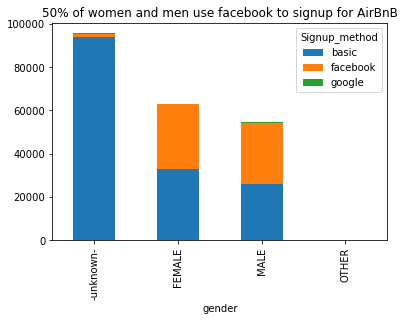

In [86]:
source_ct = pd.crosstab(gender_by_signup_method["gender"], gender_by_signup_method["signup_method"])
source_pt = gender_by_signup_method.pivot(index = "gender", \
                                    columns = "signup_method", \
                                   values = "size")
source_pt.plot.bar(stacked = True)
plt.title(label = "50% of women and men use facebook to signup for AirBnB")
plt.legend(title = "Signup_method")
plt.show()

#### Affiliate channels and providers used by customers

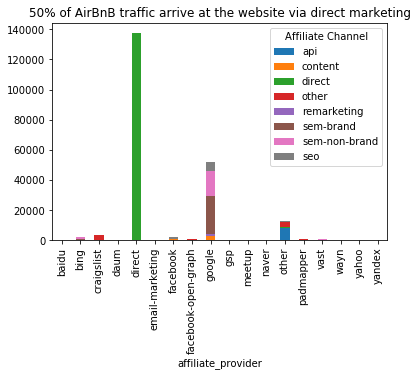

In [87]:
affiliate_provider_channel = train_user_pd_df.groupby(["affiliate_provider", \
                                                   "affiliate_channel"]).size().reset_index(name = "size")

affiliate_ct = pd.crosstab(affiliate_provider_channel["affiliate_provider"], affiliate_provider_channel["affiliate_channel"])
affiliate_pt = affiliate_provider_channel.pivot(index = "affiliate_provider", \
                                    columns = "affiliate_channel", \
                                   values = "size")
affiliate_pt.plot.bar(stacked = True)
plt.title(label = "50% of AirBnB traffic arrive at the website via direct marketing")
plt.legend(title = "Affiliate Channel")
plt.show()

Just under 50% of customers use direct marketing providers and channels.

#### Customer user experience - device type and signup app

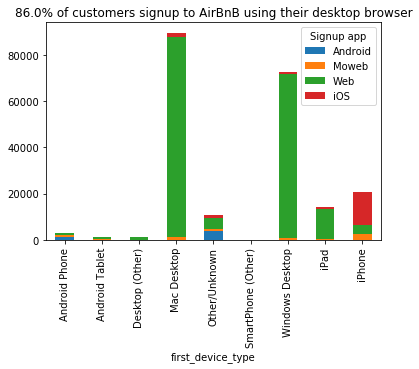

In [88]:
device_type_signupapp = train_user_pd_df.groupby(["first_device_type", \
                                                   "signup_app"]).size().reset_index(name = "size")

deviceapp_ct = pd.crosstab(device_type_signupapp["first_device_type"], device_type_signupapp["signup_app"])
deviceapp_pt = device_type_signupapp.pivot(index = "first_device_type", \
                                    columns = "signup_app", \
                                   values = "size")
deviceapp_pt.plot.bar(stacked = True)
plt.title(label = "86.0% of customers signup to AirBnB using their desktop browser")
plt.legend(title = "Signup app", \
           loc = "upper right")
plt.show()

In [89]:
device_and_signupapp = np.round((deviceapp_pt.iloc[3, 2] + deviceapp_pt.iloc[6, 2])/np.sum(deviceapp_pt)[2], 2) * 100
print("{}% of customers signup to AirBnB using their desktop browser" .format(device_and_signupapp))

86.0% of customers signup to AirBnB using their desktop browser


#### Affiliate marketing - customer's first affiliate tracked

In [90]:
first_affiliate_pd_df = train_user_pd_df[["first_affiliate_tracked"]].dropna(subset = ["first_affiliate_tracked"])
first_affiliate_hist = first_affiliate_pd_df.groupby("first_affiliate_tracked").size().reset_index(name = "freq").sort_values("freq", ascending = False).reset_index()

In [91]:
first_affiliate_hist["first_affiliate_tracked"] = first_affiliate_hist["first_affiliate_tracked"].astype(str)
first_affiliate_hist["freq"] = first_affiliate_hist["freq"].astype(int)

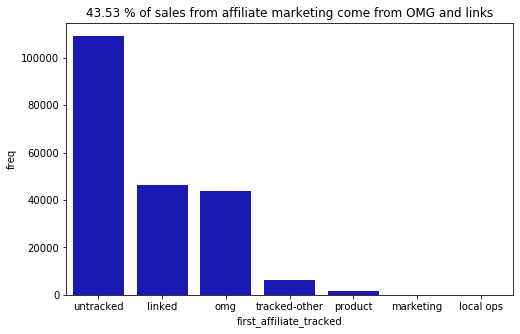

In [93]:
font = {"size": "10"}
plt.figure(figsize = (8,5))
plt.rc("font", **font)
sb.barplot(x = first_affiliate_hist["first_affiliate_tracked"], \
           y = first_affiliate_hist["freq"], \
           color = "mediumblue", orient = "v")

plt.title("43.53 % of sales from affiliate marketing come from OMG and links")
plt.show()

## Additional Exploratory Data Analysis (EDA)

#### Create column for no. of days before first booking

In [50]:
train_user_pd_df["date_first_booking"] = pd.to_datetime(train_user_pd_df["date_first_booking"], errors = "coerce")
train_user_pd_df["timestamp_first_active"] = pd.to_datetime(train_user_pd_df["timestamp_first_active"], errors = "coerce")
train_user_pd_df["days_first_booking_ts"] = ((train_user_pd_df["date_first_booking"] - train_user_pd_df["timestamp_first_active"]).dt.days)

#### Distribution of number of days until first booking

In [51]:
numdays_ts = train_user_pd_df.dropna(subset = ["days_first_booking_ts"])
numdays_ts = numdays_ts.groupby("days_first_booking_ts").size().reset_index(name = "count")
numdays_ts["days_first_booking_ts"] = numdays_ts["days_first_booking_ts"].astype(int)
numdays_ts = numdays_ts[numdays_ts["days_first_booking_ts"] >= 0]

#### Transform the days_first_booking_ts columns by taking the square root

In [52]:
numdays_ts["days_first_booking_ts"] = np.where(numdays_ts["days_first_booking_ts"] == 0, 0, \
                                                      np.sqrt(numdays_ts["days_first_booking_ts"]))

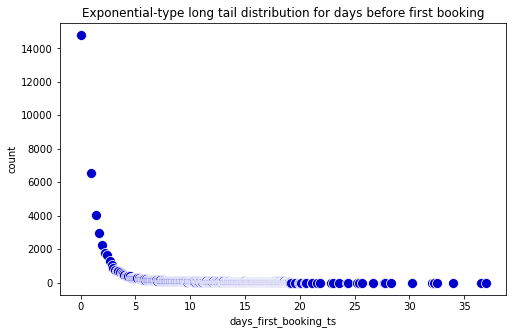

In [53]:
font = {"size": "10"}
plt.figure(figsize = (8 ,5))
plt.rc("font", **font)
sb.scatterplot(x = numdays_ts["days_first_booking_ts"], y = numdays_ts["count"], \
           color = "mediumblue", s = 100)

plt.title("Exponential-type long tail distribution for days before first booking")
plt.show()

#### Filter out all errorneous or missing days_first_booking_ts values

In [323]:
train_user_pd_df["days_first_booking_ts"] = train_user_pd_df["days_first_booking_ts"].astype(float)
train_user_pd_df2 = train_user_pd_df[(train_user_pd_df["days_first_booking_ts"] >= 0) & (~pd.isna(train_user_pd_df["days_first_booking_ts"]) == True)]

train_user_pd_df2["days_first_booking_ts2"] = np.where(train_user_pd_df2["days_first_booking_ts"] == 0, 0, \
                                                      np.sqrt(train_user_pd_df2["days_first_booking_ts"]))

### Visualize target variable (days before first booking) and categorical variables

#### Average days before first booking by gender

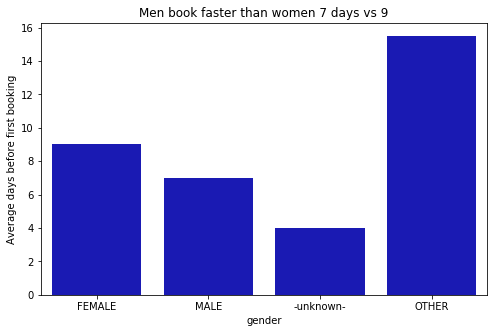

In [341]:
font = {"size": "10"}
plt.figure(figsize = (8,5))
plt.rc("font", **font)
sb.barplot(x = train_user_pd_df2["gender"], \
           y = train_user_pd_df2["days_first_booking_ts"], estimator = np.median, \
           color = "mediumblue", orient = "v", ci = None, \
          order = ["FEMALE", "MALE", "-unknown-", "OTHER"])

plt.title("Males book faster than females 7 days vs 9")
plt.ylabel("Average days before first booking")
plt.show()

#### Average days before first booking by gender and signup method

<Figure size 576x360 with 0 Axes>

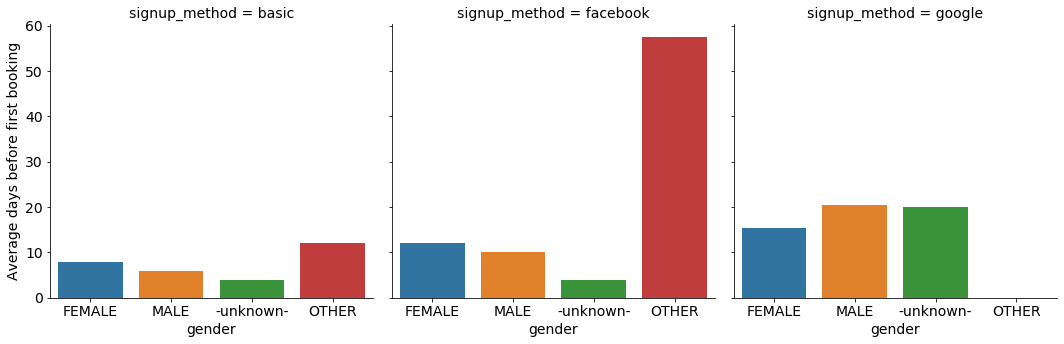

In [101]:
font = {"size": "14"}
plt.figure(figsize = (8,5))
plt.rc("font", **font)
plot = sb.catplot(x = "gender", \
           y = "days_first_booking_ts", data = train_user_pd_df2, \
           col = "signup_method", kind = "bar", \
           estimator = np.median, \
           orient = "v", ci = None, \
          order = ["FEMALE", "MALE", "-unknown-", "OTHER"])

plot.set_ylabels("Average days before first booking")
plt.show()

Males who signup with google take the longest to book - 20 days. This compares to males with basic signup = 5 days. Females who signup with facebook take 12 days to book, but those who signup with google take 15 days

#### Average days before first booking by affiliate provider and channel

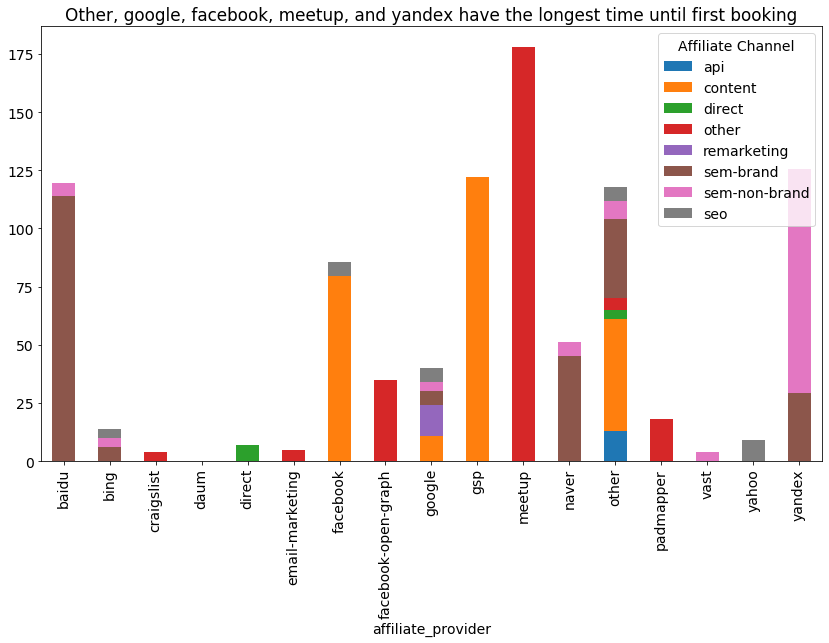

<Figure size 432x288 with 0 Axes>

In [102]:
affiliate_provider_channel = train_user_pd_df2.groupby(["affiliate_provider", \
                                                   "affiliate_channel"])["days_first_booking_ts"].median().reset_index(name = "avg_days")

affiliate_ct = pd.crosstab(affiliate_provider_channel["affiliate_provider"], affiliate_provider_channel["affiliate_channel"])
affiliate_pt = affiliate_provider_channel.pivot(index = "affiliate_provider", \
                                    columns = "affiliate_channel", \
                                   values = "avg_days")
affiliate_pt.plot.bar(stacked = True, figsize = (14, 8))
plt.title(label = "Other, google, facebook, meetup, and yandex have the longest time until first booking")
plt.legend(title = "Affiliate Channel")
plt.show()
plt.savefig("images/affiliate_provider_channel2.png")

Direct booking through AirBnB occurs above 5 days. When affiliate_provider is through most other sources it takes longer before a user books. E.g. for other, days until first booking is more than 25 days. Google has first bookings on average after 15 days. Facebook, meetup, and yandex are just above 12 days until first booking. 

#### Average days before first booking by signup_app

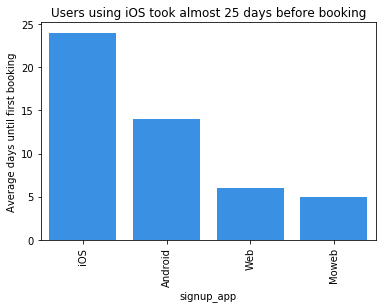

In [342]:
signup_app_df = train_user_pd_df2.groupby("signup_app")["days_first_booking_ts"].median().reset_index(name ="avg_days")
signup_app_df = signup_app_df.sort_values("avg_days", ascending =  False)

sb.barplot(x = "signup_app", \
           y = "avg_days", data = signup_app_df, color = "dodgerblue", ci = None)
plt.title("Users using iOS took almost 25 days before booking")
plt.ylabel("Average days until first booking")
plt.xticks(rotation = 90)
plt.show()


#### Average days before first booking by device type

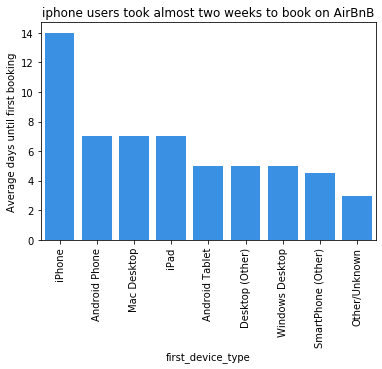

In [344]:
device_type_df = train_user_pd_df2.groupby("first_device_type")["days_first_booking_ts"].median().reset_index(name ="avg_days")
device_type_df = device_type_df.sort_values("avg_days", ascending =  False)

sb.barplot(x = "first_device_type", \
           y = "avg_days", data = device_type_df, color = "dodgerblue", ci = None)
plt.title("iphone users took almost two weeks to book on AirBnB")
plt.ylabel("Average days until first booking")
plt.xticks(rotation = 90)
plt.show()


## End of EDA

In [801]:
#######################################################################################

## Replace Missing Values

In [345]:
stat_dfb = train_user_pd_df2["days_first_booking_ts"].describe()
#print(stat)
IQR = stat_dfb["75%"] - stat_dfb["25%"]
lower_dfb = stat_dfb["25%"] - 1.5 * IQR
upper_dfb = stat_dfb["75%"] + 1.5 * IQR
print("Lower and upper bounds for outliers are {} and {}" .format(lower_dfb, upper_dfb))

train_user_pd_df_no_outliers = train_user_pd_df2[train_user_pd_df2["days_first_booking_ts"] <= \
                                         upper_dfb] #.sort(desc("mean_mins"))

Lower and upper bounds for outliers are -96.5 and 163.5


#### Drop unused columns

In [349]:
train_user_pd_df3 = train_user_pd_df_no_outliers.drop(columns = ['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'days_first_booking_ts'], axis = 1)

train_user_pd_df3 = train_user_pd_df3.reset_index(drop = True)

In [359]:
train_user_pd_df3 = train_user_pd_df2.drop(columns = ['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'days_first_booking_ts'], axis = 1)
train_user_pd_df3 = train_user_pd_df3.reset_index(drop = True)

In [561]:
train_user_pd_df3.to_csv("train_user_pd_df3.csv", index = False)

In [347]:
cat_columns =["gender", "signup_method", \
              "signup_flow", 
              "language", \
              "affiliate_channel", \
              "affiliate_provider", \
              "first_affiliate_tracked", \
              "signup_app", 
              "first_device_type", \
              "first_browser", \
              "country_destination"]

num_columns = ["age"]

In [350]:
train_user_pd_df2["days_first_booking_ts"].count()

67498

#### Impute missing values and encode categorical variables

In [351]:
def imputation_values(train_user_pd_df3, output_var, n_samples, size, \
                      cat_columns, num_columns, weights):
    

    X_imp = train_user_pd_df3[cat_columns] #.drop(columns = output_var)

   ### Replace nan and inf with 10,000

    X_imp.replace([np.nan, np.inf], 10000, inplace = True)

    X_imp = X_imp.astype(str)

     ### Encode strings as integers

    labels_lst = []
    le = LabelEncoder()
    for col in X_imp.columns:
        le_array = le.fit_transform(X_imp[col])
        labels_lst.append(le_array)
        labels_np = np.transpose(np.array(labels_lst))
        
    labels_df = pd.DataFrame(labels_np, columns = X_imp.columns).reset_index(drop = True)
    
   # labels_df = labels_df.drop(num_columns, axis = 1).reset_index()
    #print(le.inverse_transform((list(np.round(labels_df["country_destination"].astype(int))))))
    
    ##### Merge all categorical and numerical dataframes
    
    num_df = train_user_pd_df3[num_columns]#.reset_index(drop = True)
    num_df.replace([np.nan, np.inf, -np.inf], 10000, inplace = True)
    
    X_imp_df = pd.concat([labels_df, num_df], axis = 1)
    
    ### Convert all columns to numerical
    
    X_imp_df = X_imp_df.astype(float)
   
    
    ### Add output variable days_first_booking_ts2 to dataframe
   # out_var = train_user_pd_df3[output_var].reset_index(drop = True)
    X_imp_df2 = pd.concat([X_imp_df, train_user_pd_df3[output_var]], axis = 1)
    
    ###################################################################################
    
    
    ##### Use imputation to replace missing values (10,000)
    n = int(size * n_samples)
    
    impute_val = KNNImputer(missing_values = 10000, n_neighbors = n, \
                            weights = weights, copy = False)
    
    X_imp_df_samp = X_imp_df2.sample(n = n_samples, axis = 0, \
                                    random_state = 20200131)
    
    knn_model = impute_val.fit_transform(X_imp_df_samp)
    
    ##### Placeholder to save KNN model ###########################################

    #pickle.dump(knn_model, open("knn_impute_model_test.sav", "wb"))

    #with open("knn_impute_model_test.sav", "rb") as f:
    #    knn_model = pickle.load(f)

    ###############################################################################
    
    knn_imp_df = pd.DataFrame(knn_model.tolist(), columns = X_imp_df_samp.columns)
    knn_imp_df.index = X_imp_df_samp.index
    
    return knn_imp_df, le

In [352]:
%%time
num_rows = train_user_pd_df3.shape[0]
X_imp_df, label_enc = imputation_values(train_user_pd_df3, "days_first_booking_ts2", \
                                        num_rows, 1, cat_columns, num_columns, "uniform")

Wall time: 22min 38s


## Feature Selection

#### Feature selection using RFE (Recursive Feature Elimination)

In [61]:
# get a list of models to evaluate
def get_models(max_params):
    models = dict()
    for i in range(2, max_params):
        rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=i)
        model = RandomForestRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, get_df):
    
    X = get_df.drop(columns = ["days_first_booking_ts2"])
    y = get_df["days_first_booking_ts2"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.3, \
                                                       random_state = 142)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 142)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [394]:
# Get the models to evaluate
models = get_models(13)
# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_imp_df)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 -2.637 (0.018)
>3 -2.666 (0.020)
>4 -2.712 (0.021)
>5 -2.740 (0.020)
>6 -2.760 (0.018)
>7 -2.757 (0.019)
>8 -2.771 (0.027)
>9 -2.781 (0.020)
>10 -2.784 (0.021)
>11 -2.784 (0.020)
>12 -2.784 (0.019)


In [354]:
def select_features(get_df, num_features):
    
    X = get_df.drop(columns = ["days_first_booking_ts2"])
    y = get_df["days_first_booking_ts2"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.3, \
                                                       random_state = 142)
    
    rfe_model = RandomForestRegressor()

    # Create RFE model and select 8 attributes
    rfe = RFE(rfe_model, n_features_to_select = num_features, step = 1)
    rfe = rfe.fit(X_train, y_train)

    # Summarize the selection of attributes
    print(rfe.support_)
    print(rfe.ranking_)
    return

In [65]:
select_features(X_imp_df, 7)

[ True False False False  True False  True False  True  True  True  True]
[1 5 3 4 1 2 1 6 1 1 1 1]


In [402]:
X_imp_df.columns[0:-1]

Index(['gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'age'],
      dtype='object')

Gender, affiliate_channel, first_affiliate_tracked, first_device_type, first_browser, country_destination, and age are th emost important features

## Build model (generalized linear model (GLM))

In [355]:
def glm_model(get_df):
    X = (get_df.iloc[:, :-1])
    y = get_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.4, \
                                                       random_state = 20200116)

    #### Change model to Ensemble regression model

    train_const = sm.add_constant(X_train)

    tw_model = sm.GLM(y_train, exog = X_train, \
                      family = sm.families.Tweedie())

    tw_results = tw_model.fit()

    y_pred = tw_results.predict(X_test)

    print("MAD =", np.round(mean_absolute_error(y_test, y_pred), 2))

    #print("Max error =", np.round(max_error(y_test, y_pred),2))

    print("RMSE =", np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
    
    print("Actual MAD = {} days" .format(np.round(mean_absolute_error(y_test, y_pred)**2, 2)))
    print("Actual RMSE = {} days" .format(np.round(np.sqrt(mean_squared_error(y_test, y_pred)))**2, 2))
    
    print("Median (average) = {} days" .format(np.round(np.median(y_test)**2, 2)))
    
    return

In [357]:
df_columns =["gender", \
              "affiliate_channel", \
              "first_affiliate_tracked", \
              "first_device_type", \
              "first_browser", \
              "country_destination", "age", \
            "days_first_booking_ts2"]

In [360]:
glm_model(X_imp_df[df_columns])

MAD = 2.64
RMSE = 3.39
Actual MAD = 6.99 days
Actual RMSE = 9.0 days
Median (average) = 4.0 days


On average the long-tailed tweedie model predicts it takes 4 days before a customer makes a booking with an error or mean average deviation (MAD) of 7 days

The GLM Tweedie model migh not be the best choice. Further improvements in the results might lie in changing to a different model or non-linear algorithm. An ensemble decision tree (gradient boost) algorithm is chosen due to ease of use and smaller dataset compared to a neural network.

## Change model to GradientBoost (decision tree ensemble)

Important for ensembles is tuning the maximum depth, number of estimators and minimum samples split parameters.

#### Get best parameters for Gradient Boost model

In [364]:
%%time
def gridsearch_params(get_df):
    params = {"n_estimators": range(20, 81, 10), "max_depth": range(2, 16, 1), \
              "min_samples_split": range(200, 1001, 200), \
              "learning_rate": [0.01, 0.03, 0.1, 0.3]}

    gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = "lad", max_features = "sqrt", \
                                    subsample = 0.8, random_state = 20200116)
    grid_search = GridSearchCV(estimator = gbr, param_grid = params, \
                               scoring = "neg_mean_squared_error", cv = 5)

    X = (get_df.iloc[:, :-1])
    y = get_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                            test_size = 0.4, \
                                                           random_state = 20200116)

    grid_search.fit(X_train, y_train)
    grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["std_test_score"], \
    grid_search.cv_results_["params"], grid_search.best_params_, grid_search.best_score_
    
    return grid_search.best_params_


Wall time: 997 µs


In [129]:
gridsearch_params(X_imp_df)

{'learning_rate': 0.1,
 'max_depth': 15,
 'min_samples_split': 800,
 'n_estimators': 80}

#### Run gradient boost model

In [367]:
def gdb_model(get_df, maxdepth, min_samp_split, num_estimators, learning_rate):
   
    X = (get_df.iloc[:, :-1])
    y = get_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.4, \
                                                       random_state = 20200116)
    gdb = GradientBoostingRegressor(loss = "lad", \
                                           n_estimators = num_estimators, \
                                           max_depth = maxdepth, \
                                          min_samples_split = min_samp_split, \
                                    learning_rate = learning_rate, \
                                              random_state = 20200116, \
                                              max_features = "sqrt"
                                              )
    gdb_results_md = gdb.fit(X_train, y_train)
    train_score = np.mean(gdb_results_md.train_score_)
    max_error_score = np.max(gdb_results_md.loss_(y_test, gdb_results_md.predict(X_test)))
    test_score = gdb_results_md.loss_(y_test, gdb_results_md.predict(X_test))
     
    MAD_trainscore = np.round(train_score, 2)
    MAD_testscore = np.round(test_score, 2)
    Max_error = np.round(max_error_score, 2)
    Actual_MAD_trainscore = np.round(train_score**2, 2)
    Actual_MAD_testscore = np.round(test_score**2, 2)
    Median = np.round(np.median(gdb_results_md.predict(X_test))**2, 2)
    
    
    gdb_md = pd.DataFrame({
    "metrics": [MAD_trainscore, MAD_testscore, \
                Actual_MAD_trainscore, Actual_MAD_testscore, \
               Median]
    
    })
    gdb_md.index = ["MAD_trainscore", "MAD_testscore", \
                "Actual_MAD_trainscore", "Actual_MAD_testscore", \
                    "Median"]
    
    return gdb_md


In [368]:
gdb_model(X_imp_df[df_columns], 15, 800, 80, 0.1)

,metrics
MAD_trainscore,2.39
MAD_testscore,2.44
Actual_MAD_trainscore,5.73
Actual_MAD_testscore,5.95
Median,3.82


The average days until first booking decreased from 4 days to 3.82 days. The MAD (error) also decreased to 5.95 (from 7).

## Add variable - average time spent in a session

#### Add the average time a user spends in a session as a variable

In [382]:
%%time
session_time_df = sqlContext.sql("SELECT user_id as id, \
                        COUNT(action) as num_sessions, \
                        ROUND(SUM(secs_elapsed)/60, 2) as total_mins, \
                        ROUND((SUM(secs_elapsed)/60)/COUNT(action), 2) as avg_mins_session, \
                          ROUND(PERCENTILE_APPROX(secs_elapsed, 0.5), 2) AS avg_secs, \
                        ROUND(PERCENTILE_APPROX(secs_elapsed, 0.5)/60, 2) AS avg_mins \
                        FROM session_df \
                        GROUP BY user_id \
          ")
session_time_pd_df = session_time_df.toPandas()

Wall time: 7.25 s


In [383]:
IQR_session = (1.5 * session_time_pd_df['avg_mins_session'].quantile(0.75)) - (1.5 * session_time_pd_df["avg_mins_session"].quantile(0.25)) 
outlier_cutoff_session_time = session_time_pd_df['avg_mins_session'].quantile(0.75) + IQR_session

In [385]:
session_time_pd_df = session_time_pd_df[(session_time_pd_df['avg_mins_session'] <= \
                                          outlier_cutoff_session_time)]

In [386]:
session_time_pd_df["avg_mins_session"].describe()

count    13887.000000
mean       365.450397
std        302.386159
min          0.340000
25%        139.220000
50%        280.770000
75%        520.900000
max       1339.140000
Name: avg_mins_session, dtype: float64

#### Add session data to other variables

In [387]:
train_user_pd_df2.reset_index(drop = True, inplace = True)
X_imp_df.reset_index(drop = True, inplace = True)

In [388]:
X_imp_temp_df = pd.concat([train_user_pd_df2["id"], X_imp_df], axis = 1).reset_index(drop = True)
X_imp_df_session = X_imp_temp_df.merge(session_time_pd_df[["id", 'avg_mins_session']], on = "id", how = "inner").reset_index(drop = True)
X_imp_df_session = X_imp_df_session.drop(columns = "id")

In [389]:
X_imp_df_session.columns

Index(['gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'age', 'days_first_booking_ts2',
       'avg_mins_session'],
      dtype='object')

#### Correlation between days before first booking and average minutes per session

In [390]:
ss.pearsonr(X_imp_df_session["days_first_booking_ts2"], X_imp_df_session["avg_mins_session"])[0]

0.004041887166784313

#### Distribution of average minutes in a session (avg_mins_session)

In [392]:
#session_time_pd_df["avg_mins_session"] = (~pd.isna(session_time_pd_df["avg_mins_session"]) == True)
session_time_pd_df2 = session_time_pd_df.dropna()
session_data = session_time_pd_df2[["avg_mins_session"]].astype(int)
sessions = session_data.groupby("avg_mins_session").size().reset_index(name = "count")
sessions["avg_mins_session"] = sessions["avg_mins_session"].astype(int)
sessions = sessions[sessions["avg_mins_session"] >= 0]

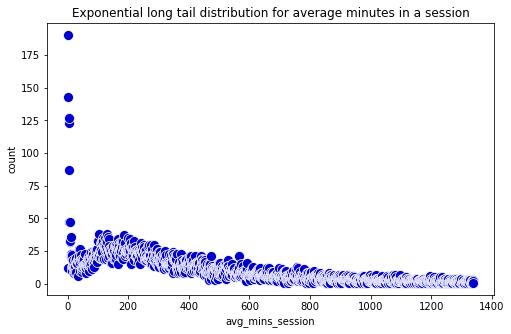

In [393]:
font = {"size": "10"}
plt.figure(figsize = (8,5))
plt.rc("font", **font)
sb.scatterplot(x = np.round(sessions["avg_mins_session"]), \
               y = sessions["count"], #data = sessions, \
           color = "mediumblue", s = 100)

plt.title("Exponential long tail distribution for average minutes in a session")
#plt.xticks(ticks = np.arange(0, 500, step = 3
 #                            00), rotation = 90)
plt.show()

In [394]:
X_imp_df_session["days_first_booking_ts2"].describe()

count    4133.000000
mean        3.095990
std         3.343318
min         0.000000
25%         0.000000
50%         2.000000
75%         4.472136
max        12.767145
Name: days_first_booking_ts2, dtype: float64

In [829]:
### Impact of no of days first booking on AirBnB 

In [247]:
X_imp_df_session.dropna(inplace = True)

In [535]:
# Get the models to evaluate
models = get_models(14)
# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_imp_df_session)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 -2.673 (0.018)
>3 -2.717 (0.024)
>4 -2.770 (0.027)
>5 -2.788 (0.029)
>6 -2.813 (0.028)
>7 -2.823 (0.025)
>8 -2.832 (0.023)
>9 -2.831 (0.019)
>10 -2.832 (0.021)
>11 -2.833 (0.022)
>12 -2.834 (0.021)
>13 -2.834 (0.022)


In [306]:
select_features(X_imp_df_session, 8)

[ True False False False  True False  True False  True  True  True  True
  True]
[1 4 2 6 1 3 1 5 1 1 1 1 1]


In [305]:
X_imp_df_session.drop(columns = "days_first_booking_ts2", axis = 1).columns

Index(['gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'age', 'avg_mins_session'],
      dtype='object')

Length of time a user spends in a session is an important feature in converting users to paying  customers

In [395]:
session_df_columns = ["gender", \
              "affiliate_channel", "first_affiliate_tracked", \
              "first_device_type", "first_browser", \
              "country_destination", "age", \
                     "days_first_booking_ts2",  "avg_mins_session"]

In [397]:
X_imp_df_session2 = X_imp_df_session[session_df_columns]

In [398]:
gdb_model(X_imp_df_session2, 15, 800, 80, 0.1)

,metrics
MAD_trainscore,0.78
MAD_testscore,0.36
Actual_MAD_trainscore,0.60
Actual_MAD_testscore,0.13
Median,4.23


In [337]:
X_imp_df_session.shape[0]

4514

It takes 4.23 days before a user first books on AirBnB. This is an increase of 0.23 without the average minutes in a session variable.
When session data is included the MAD (median absolute deviation) decreases drastically from 7 to 0.13. However the test score is lower than the train score which shows there is a variance problem. In this case the model can be improve by having more data.
There are only 4514 rows in the data.